# SAD - Synthetic Augmented Data Generator

This jupyter notebook allows a quick try out of our code.

## Table of Content

1) Preparation for Notebook

2) Creating Synthetic Data

3) Automatically augmenting real world data

4) Manually augmenting real world data


## Preparation for Notebook
Steps that are necessary before executing this notebook:
1) Create a virtual Python environment

For Linux
```bash
python3 -m venv venv4datagenerator
source venv4datagenerator/bin/activate
```
For Windows
```bash
python -m venv venv4datagenerator
venv4datagenerator\Scripts\activate.bat
```

2) Install dependencies
```
pip install -r requirements.txt
```

3) Launch Jupyter Notebook
```bash
jupyter notebook
```

## Chunks

The data generator picks the basic building blocks (chunks) from the folder `chunks` to dynamically create and annotate a ground plane. There are four different chunk types: `curve_left`, `curve_right`, `line` and `intersection`. For every chunk type there has to exist exactly one label and at least one image. If multiple images exist for one type they would be called variants of the chunk. The label contains the semantic information of the chunk. The image is the visual appearance of the road element. Every chunk type has a correspondent JSON file with its metadata. One important meta information is the ideal path that the car would take through the chunk.

This figure shows how the ground plane is modularily constructed from chunks.
<img width="50%" src="https://user-images.githubusercontent.com/88937076/138558644-222a3bcd-ea1d-46ec-918f-5033dd79b3ef.png"></img>

In our example the chunks represent the building blocks of a miniature track for a model car. By changing the chunk images, one can adapt the data generator to their own self-driving task. The chunk images need a consistent scale and size which has to be defined in the [config](CONFIG.md). Additionally the images have to be in the bird's-eye-view.

Run the following code block to see all available chunks in our demonstrator.


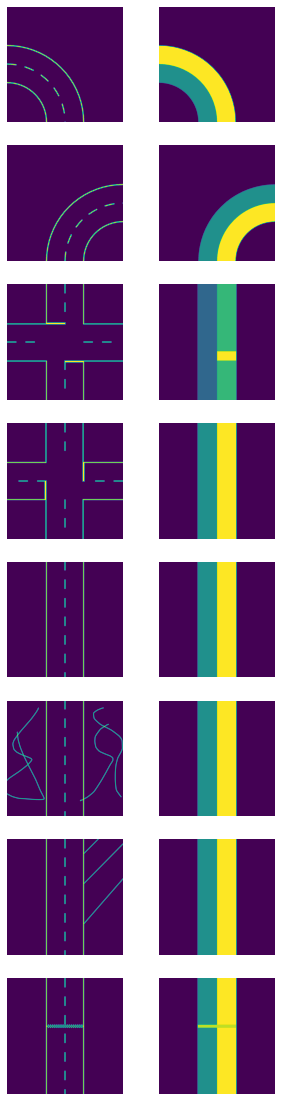

In [1]:
"""Plot all available chunks."""

import cv2
import glob
import matplotlib.pyplot as plt

annotations_list = glob.glob(".\chunks\*segment*.png")
len_list = len(annotations_list)

fig = plt.figure(figsize=(5, 20))

columns = 2
rows = len_list
for i in range(1, len_list+1):
    annotation_path = annotations_list[i-1]
    img = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    fig.add_subplot(rows, columns, 2*i)
    plt.axis('off')
    plt.imshow(img)

    img_path = annotation_path.replace("segment", "nice")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    fig.add_subplot(rows, columns, 2*i-1)
    plt.axis('off')
    
    try:
        plt.imshow(img)
    except:
        print("Following image was not found: " + str(img_path))
plt.show()


## Obstacles and Overlays

Overlays are random distracting images which the data generator puts on the camera image to enhance the variety of the dataset. They serve as disturbing artifacts and do not affect the annotations of the images because they do not belong to a segmentation class. The user can add their own overlays inside the folder `overlays`.

The obstacle images are added to the camera images and the annotations using the `obstacle_class` defined in the config file. Compared to the overlays, they do affect the annotations of the images because they do belong to a segmentation class. Therefore they represent objects that have to be classified by the network.  In our example the objects are obstacles.

Run the following code block to see some examples of overlays and obstacles in our demonstrator.

Example of Obstacles


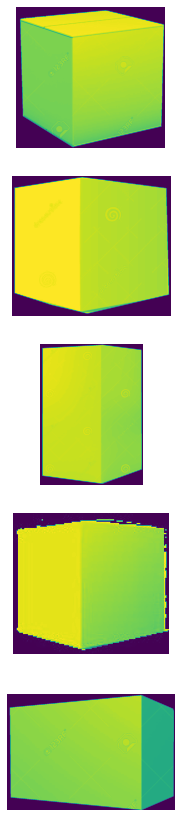

Example of Overlays


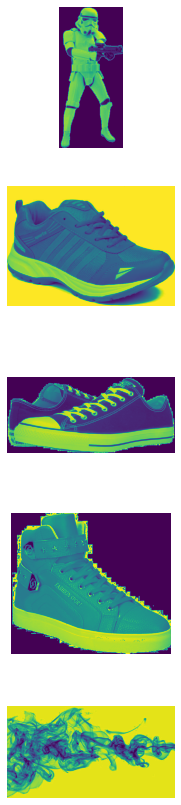

In [10]:
"""Plot some examples of obstacles and overlays."""

import cv2
import glob
import matplotlib.pyplot as plt

obstacle_list = glob.glob(".\obstacles\*.jpg")
overlay_list = glob.glob(".\overlays\*.png")

columns = 1
rows = 5

print("Example of Obstacles")
fig_obstacle = plt.figure(figsize=(3, 15))
for i in range(1, rows+1):
    obstacle_path = obstacle_list[i-1]
    img = cv2.imread(obstacle_path, cv2.IMREAD_GRAYSCALE)
    fig_obstacle.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

print("Example of Overlays")
fig_overlay = plt.figure(figsize=(3, 15))
for i in range(1, rows+1):
    overlay_path = overlay_list[i-1]
    img = cv2.imread(overlay_path, cv2.IMREAD_GRAYSCALE)
    fig_overlay.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [ ]:
import os
import time
import random
import argparse
import numpy as np

from config import Config
import road
import render
from disturbances import *
import augment
from main import *
from startline import Startline
from manual_augment import ManualAugment

The JSON configuration file `config1.json` is used for most of the configuration.
The full reference is available in [CONFIG.md](CONFIG.md).



In [ ]:
    config = Config("config1.json", debug=False)
    if config["seed"]:
        random.seed(config["seed"])
        np.random.seed(config["seed"])

    output_path_annotations = config["paths"]["annotations_output_path"]
    output_path_images = config["paths"]["images_output_path"]

    for name, split in config["splits"].items():
        os.makedirs(output_path_annotations.format(splitname=name),
                    exist_ok=True)
        os.makedirs(output_path_images.format(splitname=name), exist_ok=True)
        print("generating split", name)
        print("synthetic")
        print()
        idcs = list(range(split["size"]))
        if config["shuffle"]:
            random.shuffle(idcs)
        generate_synthetic(
            config,
            name,
            idcs[round(
                (1 - split["fraction_synthetic"]) *
                split["size"]):])

        print("augmented")
        generate_augmented(
            config,
            name,
            idcs[:round(
                split["fraction_augmented"] *
                split["size"])])

In [ ]:
    startline = Startline()
    index = 0

    startline_img, startline_mask = startline.draw_startline()

    annotations_list = glob.glob("./real_dataset/annotations/set_*/*.png")

    startline_img_, startline_mask_ = startline.create_overlay(startline_img)

    if len(annotations_list) == 0:
        print("no annotated images found under the path")

    for mask_path in annotations_list:
        img_path = mask_path.replace("annotations", "images")
        camera_img, camera_mask = startline.import_annotated_data(
                img_path, mask_path)
        bird_img, bird_mask = startline.get_birds_eye_view(
                camera_img, camera_mask)

        startline_img, startline_mask = (np.copy(startline_img_),
                                         np.copy(startline_mask_))
        key = 0
        while key != ord(" ") or ord("q"):

            startline_img, startline_mask = startline.transform_image(
                    startline_img, startline_mask, key)

            (bird_img_n, bird_mask_n,
             camera_img_n, camera_mask_n) = startline.merge_bird_overlay(
                    np.copy(startline_img), np.copy(startline_mask),
                    np.copy(bird_img), np.copy(bird_mask),
                    np.copy(camera_img), np.copy(camera_mask))
            key = startline.visualize_augmentation(bird_mask_n, bird_img_n,
                                                   camera_img_n, camera_mask_n,
                                                   index)

            if key == ord(" "):
                break
            if key == ord("q"):
                break
            if key == 27:
                exit()
        index += 1